In [1]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src.dataset.utils as dutils
import src.modelling.utils as mutils
from src.modelling.resnet_model import ResNet

%load_ext autoreload
%autoreload 2

In [2]:
MODEL_DIR = './models/'
DATA_DIR = './data/'

print("Avaliable trained models:\n")
for file in os.listdir(MODEL_DIR):
    print(file)

Avaliable trained models:

resnet_Adam_2024-02-18-11:16:04.pth
resnet_RMSprop_2024-02-18-11:55:42.pth
resnet_SGD_2024-02-18-11:48:40.pth
resnet_SGD_2024-02-18-11:17:46.pth
resnet_Adam_2024-02-18-11:34:08.pth
resnet_Adam_2024-02-18-11:41:55.pth
resnet_RMSprop_2024-02-18-11:19:33.pth


In [3]:
model_filepath = os.path.join(MODEL_DIR, 'resnet_SGD_2024-02-18-11:48:40.pth')

model = ResNet(in_channels=3, n_classes=4)
model.load_state_dict(torch.load(model_filepath))

image_transformer = dutils.get_default_image_transformer()

test_loader = DataLoader(
    dataset=ImageFolder(os.path.join(DATA_DIR, "test"), transform=image_transformer),
    batch_size=5
)

predicted, expected = mutils.evaluate_model(model=model, loader=test_loader)

100%|████████████████████████████████████████████████████████████████████████████| 169/169 [00:06<00:00, 27.71it/s]

Accuracy for test set: 0.9289940828402367


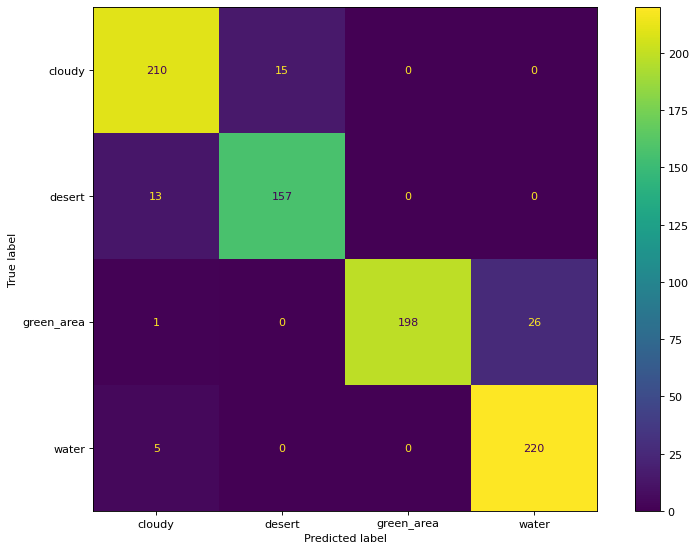

In [4]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=80)

cmp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(expected, predicted),
    display_labels=dutils.CLASS_MAPPER.values(),
)

cmp.plot(ax=ax)

fig.tight_layout()
fig.savefig('./images/confusion_matrix.png', bbox_inches='tight')

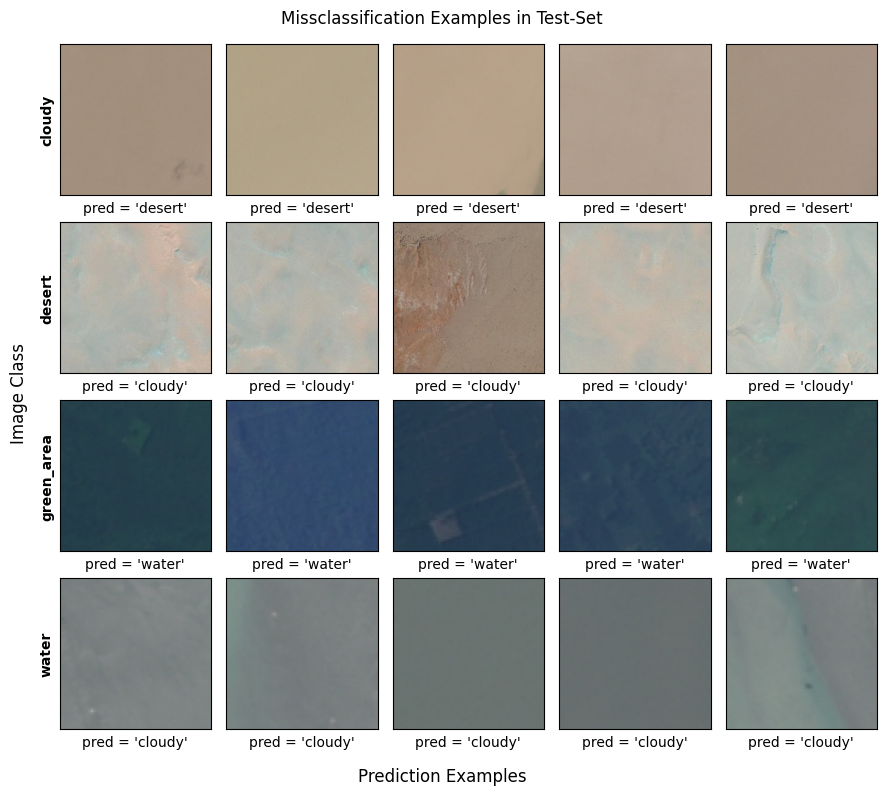

In [6]:
IMAGES_PER_ROW = 5
fig, axs = plt.subplots(len(dutils.CLASS_MAPPER.keys()), IMAGES_PER_ROW, figsize=(9, 8))

for i, cls in enumerate(dutils.CLASS_MAPPER.keys()):
    mask = np.logical_and(expected == cls, (predicted != expected)) # missed classifications for the current class
    
    missclassified_image_indexes = np.where(mask)[0]
    missclassified_image_files = [test_loader.dataset.samples[i][0] for i in missclassified_image_indexes]
    errors = predicted[missclassified_image_indexes]

    for j, file in enumerate(missclassified_image_files[:IMAGES_PER_ROW]):
        img = read_image(file)
        img = img.permute(2, 1, 0)
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel(f"pred = '{dutils.CLASS_MAPPER[errors[j]]}'")

    axs[i, 0].set_ylabel(dutils.CLASS_MAPPER[cls], weight='bold')

fig.suptitle("Missclassification Examples in Test-Set")
fig.supylabel("Image Class")
fig.supxlabel("Prediction Examples")
fig.tight_layout()
fig.savefig('./images/missclassifications_per_class.png', bbox_inches='tight')